# Procurement KPI Analytics - Data Cleaning

**Objective**: Clean and standardize procurement data to ensure high quality for analysis and modeling.

**Key Tasks**:
- Handle missing values and data inconsistencies
- Standardize date formats and categorical variables
- Identify and handle outliers
- Validate data integrity and business rules
- Create clean datasets for downstream analysis

**Input**: Raw procurement dataset

**Output**: Clean, validated dataset ready for analysis

---

## 1. Setup and Data Loading

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
import re
from typing import List, Tuple, Dict, Any

# Optional imports with fallback
try:
    from scipy import stats
    SCIPY_AVAILABLE = True
except ImportError:
    print("Warning: scipy not available. Some outlier detection methods will be limited.")
    SCIPY_AVAILABLE = False

# Configure display and warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

print("Libraries loaded successfully!")
print(f"Analysis timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Libraries loaded successfully!
Analysis timestamp: 2025-07-08 22:01:25


In [3]:
# Load the raw dataset
try:
    df_raw = pd.read_csv('../data/raw/Procurement_KPI_Analysis_Dataset.csv')
    print("Raw dataset loaded successfully!")
    print(f"Original dataset shape: {df_raw.shape[0]:,} rows x {df_raw.shape[1]} columns")
except FileNotFoundError:
    print("Error: Dataset not found. Please ensure the file exists in '../data/raw/'")
    print("Expected filename: 'Procurement_KPI_Analysis_Dataset.csv'")

# Create working copy
df = df_raw.copy()
print(f"Working dataset created with {len(df):,} records")

Raw dataset loaded successfully!
Original dataset shape: 777 rows x 11 columns
Working dataset created with 777 records


In [4]:
# Initial data overview
print("Initial Data Overview:")
print("=" * 50)
print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nColumn data types:")
display(df.dtypes.to_frame('Data_Type'))

print("\nFirst 3 rows:")
display(df.head(3))

Initial Data Overview:
Dataset shape: (777, 11)
Memory usage: 0.32 MB

Column data types:


,Data_Type
PO_ID,object
Supplier,object
Order_Date,object
Delivery_Date,object
Item_Category,object
Order_Status,object
Quantity,int64
Unit_Price,float64
Negotiated_Price,float64
Defective_Units,float64



First 3 rows:


,PO_ID,Supplier,Order_Date,Delivery_Date,Item_Category,Order_Status,Quantity,Unit_Price,Negotiated_Price,Defective_Units,Compliance
0,PO-00001,Alpha_Inc,2023-10-17,2023-10-25,Office Supplies,Cancelled,1176,20.13,17.81,NaN,Yes
1,PO-00002,Delta_Logistics,2022-04-25,2022-05-05,Office Supplies,Delivered,1509,39.32,37.34,235.00,Yes
2,PO-00003,Gamma_Co,2022-01-26,2022-02-15,MRO,Delivered,910,95.51,92.26,41.00,Yes


## 2. Data Quality Assessment

In [5]:
# Comprehensive data quality assessment
def assess_data_quality(df: pd.DataFrame) -> pd.DataFrame:
    """
    Comprehensive data quality assessment function.
    """
    quality_report = pd.DataFrame({
        'Column': df.columns,
        'Data_Type': df.dtypes,
        'Non_Null_Count': df.count(),
        'Null_Count': df.isnull().sum(),
        'Null_Percentage': (df.isnull().sum() / len(df) * 100).round(2),
        'Unique_Count': df.nunique(),
        'Duplicate_Percentage': ((df.count() - df.nunique()) / df.count() * 100).round(2)
    })
    
    # Add additional quality metrics for numerical columns
    quality_report['Has_Zeros'] = False
    quality_report['Has_Negatives'] = False
    
    for col in df.select_dtypes(include=[np.number]).columns:
        quality_report.loc[quality_report['Column'] == col, 'Has_Zeros'] = (df[col] == 0).any()
        quality_report.loc[quality_report['Column'] == col, 'Has_Negatives'] = (df[col] < 0).any()
    
    return quality_report

# Generate quality report
print("Data Quality Assessment:")
print("=" * 50)
quality_report = assess_data_quality(df)
display(quality_report)

Data Quality Assessment:


,Column,Data_Type,Non_Null_Count,Null_Count,Null_Percentage,Unique_Count,Duplicate_Percentage,Has_Zeros,Has_Negatives
PO_ID,PO_ID,object,777,0,0.00,777,0.00,False,False
Supplier,Supplier,object,777,0,0.00,5,99.36,False,False
Order_Date,Order_Date,object,777,0,0.00,476,38.74,False,False
Delivery_Date,Delivery_Date,object,690,87,11.20,449,34.93,False,False
Item_Category,Item_Category,object,777,0,0.00,5,99.36,False,False
Order_Status,Order_Status,object,777,0,0.00,4,99.49,False,False
Quantity,Quantity,int64,777,0,0.00,623,19.82,False,False
Unit_Price,Unit_Price,float64,777,0,0.00,747,3.86,False,False
Negotiated_Price,Negotiated_Price,float64,777,0,0.00,752,3.22,False,False
Defective_Units,Defective_Units,float64,641,136,17.50,202,68.49,True,False


In [7]:
# Identify critical data quality issues
print("Critical Data Quality Issues:")
print("=" * 50)

issues_found = []

# Check for missing values
missing_cols = quality_report[quality_report['Null_Count'] > 0]['Column'].tolist()
if missing_cols:
    issues_found.append(f"Missing values in columns: {', '.join(missing_cols)}")

# Check for potential ID column issues
if 'PO_ID' in df.columns:
    duplicate_ids = df['PO_ID'].duplicated().sum()
    if duplicate_ids > 0:
        issues_found.append(f"Duplicate PO_IDs found: {duplicate_ids} records")

# Check for negative values where they shouldn't exist
value_columns = ['Quantity', 'Unit_Price', 'Negotiated_Price', 'Defective_Units']
for col in value_columns:
    if col in df.columns and (df[col] < 0).any():
        neg_count = (df[col] < 0).sum()
        issues_found.append(f"Negative values in {col}: {neg_count} records")

# Check for unrealistic defective units (more than quantity)
if 'Defective_Units' in df.columns and 'Quantity' in df.columns:
    unrealistic_defects = (df['Defective_Units'] > df['Quantity']).sum()
    if unrealistic_defects > 0:
        issues_found.append(f"Defective units > Quantity: {unrealistic_defects} records")

# Check for price inconsistencies
if 'Unit_Price' in df.columns and 'Negotiated_Price' in df.columns:
    price_increases = (df['Negotiated_Price'] > df['Unit_Price']).sum()
    if price_increases > 0:
        issues_found.append(f"Negotiated price > unit price: {price_increases} records")

if issues_found:
    for i, issue in enumerate(issues_found, 1):
        print(f"{i}. {issue}")
else:
    print("No critical data quality issues detected!")

Critical Data Quality Issues:
1. Missing values in columns: Delivery_Date, Defective_Units


## 3. Handle Missing Values

Missing Value Analysis:
Columns with missing values:
  Defective_Units: 136 missing (17.50%)
  Delivery_Date: 87 missing (11.20%)


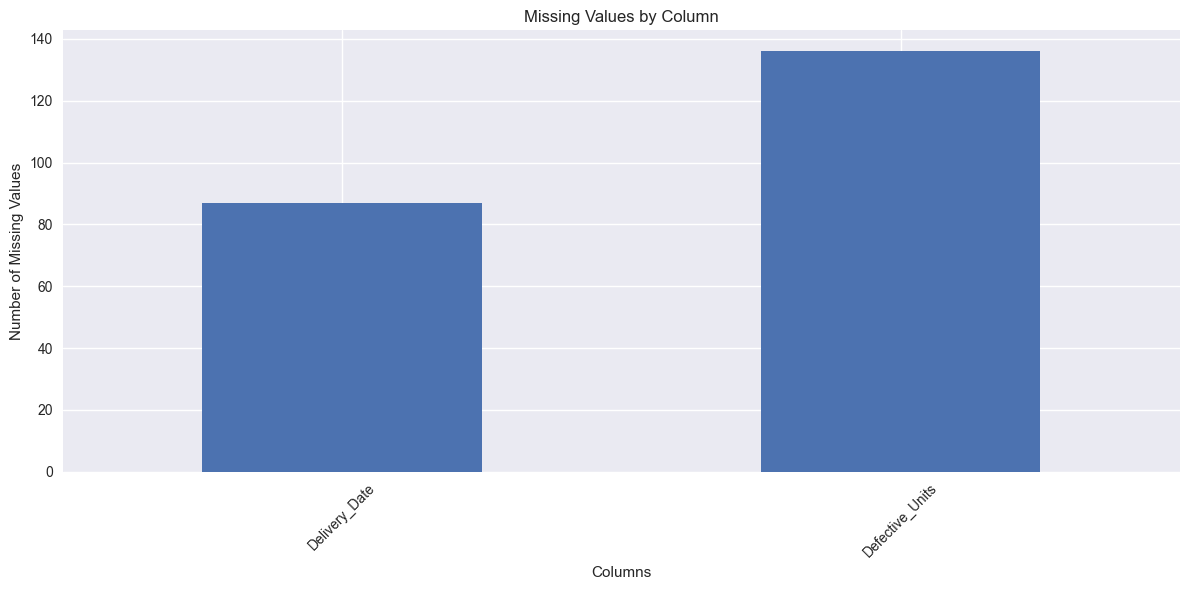

In [6]:
# Analyze missing value patterns
print("Missing Value Analysis:")
print("=" * 50)

missing_summary = df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)

if len(missing_summary) > 0:
    print("Columns with missing values:")
    for col, count in missing_summary.items():
        percentage = (count / len(df) * 100)
        print(f"  {col}: {count:,} missing ({percentage:.2f}%)")
    
    # Visualize missing value patterns
    plt.figure(figsize=(12, 6))
    missing_data = df.isnull().sum()
    missing_data = missing_data[missing_data > 0]
    
    if len(missing_data) > 0:
        missing_data.plot(kind='bar')
        plt.title('Missing Values by Column')
        plt.xlabel('Columns')
        plt.ylabel('Number of Missing Values')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
else:
    print("No missing values detected in the dataset!")

In [7]:
# Handle missing values based on business logic
def handle_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Handle missing values using domain-specific business logic.
    """
    df_clean = df.copy()
    
    # Track changes
    changes_log = []
    
    # Handle missing Defective_Units (assume 0 if missing)
    if 'Defective_Units' in df_clean.columns and df_clean['Defective_Units'].isnull().any():
        missing_count = df_clean['Defective_Units'].isnull().sum()
        df_clean['Defective_Units'] = df_clean['Defective_Units'].fillna(0)
        changes_log.append(f"Filled {missing_count} missing Defective_Units with 0")
    
    # Handle missing Compliance (investigate patterns)
    if 'Compliance' in df_clean.columns and df_clean['Compliance'].isnull().any():
        missing_count = df_clean['Compliance'].isnull().sum()
        # For now, mark as 'Unknown' - may need domain expert input
        df_clean['Compliance'] = df_clean['Compliance'].fillna('Unknown')
        changes_log.append(f"Filled {missing_count} missing Compliance values with 'Unknown'")
    
    # Handle missing dates (would need business rules)
    date_columns = ['Order_Date', 'Delivery_Date']
    for col in date_columns:
        if col in df_clean.columns and df_clean[col].isnull().any():
            missing_count = df_clean[col].isnull().sum()
            changes_log.append(f"Found {missing_count} missing values in {col} - requires business decision")
    
    # Log all changes
    if changes_log:
        print("Missing value handling actions:")
        for change in changes_log:
            print(f"  - {change}")
    else:
        print("No missing value handling required.")
    
    return df_clean

# Apply missing value handling
print("Handling Missing Values:")
print("=" * 50)
df_cleaned = handle_missing_values(df)

# Verify missing value handling
remaining_missing = df_cleaned.isnull().sum().sum()
print(f"\nRemaining missing values after cleaning: {remaining_missing}")

Handling Missing Values:
Missing value handling actions:
  - Filled 136 missing Defective_Units with 0
  - Found 87 missing values in Delivery_Date - requires business decision

Remaining missing values after cleaning: 87


## 4. Standardize Data Formats

In [8]:
# Standardize categorical variables
def standardize_categorical_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Standardize categorical variables for consistency.
    """
    df_std = df.copy()
    
    # Standardize text columns
    text_columns = ['Supplier', 'Item_Category', 'Order_Status', 'Compliance']
    
    for col in text_columns:
        if col in df_std.columns:
            # Remove leading/trailing whitespace and standardize case
            df_std[col] = df_std[col].astype(str).str.strip()
            
            # Show unique values before standardization
            print(f"\n{col} - Unique values before standardization: {df_std[col].nunique()}")
            if df_std[col].nunique() <= 20:
                print(f"Values: {sorted(df_std[col].unique())}")
            
            # Standardize specific columns
            if col == 'Order_Status':
                # Standardize order status values
                status_mapping = {
                    'completed': 'Completed',
                    'COMPLETED': 'Completed',
                    'complete': 'Completed',
                    'pending': 'Pending',
                    'PENDING': 'Pending',
                    'cancelled': 'Cancelled',
                    'CANCELLED': 'Cancelled',
                    'canceled': 'Cancelled'
                }
                df_std[col] = df_std[col].replace(status_mapping)
            
            elif col == 'Compliance':
                # Standardize compliance values
                compliance_mapping = {
                    'yes': 'Compliant',
                    'YES': 'Compliant',
                    'y': 'Compliant',
                    'compliant': 'Compliant',
                    'COMPLIANT': 'Compliant',
                    'no': 'Non-Compliant',
                    'NO': 'Non-Compliant',
                    'n': 'Non-Compliant',
                    'non-compliant': 'Non-Compliant',
                    'NON-COMPLIANT': 'Non-Compliant',
                    'noncompliant': 'Non-Compliant'
                }
                df_std[col] = df_std[col].replace(compliance_mapping)
            
            # Show unique values after standardization
            print(f"{col} - Unique values after standardization: {df_std[col].nunique()}")
            if df_std[col].nunique() <= 20:
                print(f"Values: {sorted(df_std[col].unique())}")
    
    return df_std

print("Standardizing Categorical Data:")
print("=" * 50)
df_cleaned = standardize_categorical_data(df_cleaned)

Standardizing Categorical Data:

Supplier - Unique values before standardization: 5
Values: ['Alpha_Inc', 'Beta_Supplies', 'Delta_Logistics', 'Epsilon_Group', 'Gamma_Co']
Supplier - Unique values after standardization: 5
Values: ['Alpha_Inc', 'Beta_Supplies', 'Delta_Logistics', 'Epsilon_Group', 'Gamma_Co']

Item_Category - Unique values before standardization: 5
Values: ['Electronics', 'MRO', 'Office Supplies', 'Packaging', 'Raw Materials']
Item_Category - Unique values after standardization: 5
Values: ['Electronics', 'MRO', 'Office Supplies', 'Packaging', 'Raw Materials']

Order_Status - Unique values before standardization: 4
Values: ['Cancelled', 'Delivered', 'Partially Delivered', 'Pending']
Order_Status - Unique values after standardization: 4
Values: ['Cancelled', 'Delivered', 'Partially Delivered', 'Pending']

Compliance - Unique values before standardization: 2
Values: ['No', 'Yes']
Compliance - Unique values after standardization: 2
Values: ['No', 'Yes']


In [9]:
# Standardize date formats
def standardize_dates(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert and standardize date columns.
    """
    df_dates = df.copy()
    
    date_columns = ['Order_Date', 'Delivery_Date']
    
    for col in date_columns:
        if col in df_dates.columns:
            print(f"\nProcessing {col}:")
            print(f"  Sample values: {df_dates[col].head(3).tolist()}")
            
            try:
                # Convert to datetime
                df_dates[col] = pd.to_datetime(df_dates[col], errors='coerce')
                
                # Check for invalid dates
                invalid_dates = df_dates[col].isnull().sum()
                if invalid_dates > 0:
                    print(f"  Warning: {invalid_dates} invalid dates found")
                
                # Show date range
                if not df_dates[col].isnull().all():
                    print(f"  Date range: {df_dates[col].min()} to {df_dates[col].max()}")
                    print(f"  Total days span: {(df_dates[col].max() - df_dates[col].min()).days} days")
                
            except Exception as e:
                print(f"  Error converting {col}: {e}")
    
    return df_dates

print("Standardizing Date Formats:")
print("=" * 50)
df_cleaned = standardize_dates(df_cleaned)

Standardizing Date Formats:

Processing Order_Date:
  Sample values: ['2023-10-17', '2022-04-25', '2022-01-26']
  Date range: 2022-01-01 00:00:00 to 2024-01-01 00:00:00
  Total days span: 730 days

Processing Delivery_Date:
  Sample values: ['2023-10-25', '2022-05-05', '2022-02-15']
  Date range: 2022-01-06 00:00:00 to 2024-01-12 00:00:00
  Total days span: 736 days


## 5. Data Validation and Business Rules

In [10]:
# Implement business rule validations
def validate_business_rules(df: pd.DataFrame) -> Tuple[pd.DataFrame, List[str]]:
    """
    Validate data against business rules and flag violations.
    """
    df_validated = df.copy()
    violations = []
    
    print("Business Rule Validation:")
    print("=" * 40)
    
    # Rule 1: Quantity must be positive
    if 'Quantity' in df_validated.columns:
        invalid_qty = (df_validated['Quantity'] <= 0).sum()
        if invalid_qty > 0:
            violations.append(f"Rule 1 Violation: {invalid_qty} records with non-positive quantity")
            print(f"  Rule 1: Found {invalid_qty} records with invalid quantity")
        else:
            print("  Rule 1: All quantities are positive - PASS")
    
    # Rule 2: Defective units cannot exceed total quantity
    if 'Defective_Units' in df_validated.columns and 'Quantity' in df_validated.columns:
        excess_defects = (df_validated['Defective_Units'] > df_validated['Quantity']).sum()
        if excess_defects > 0:
            violations.append(f"Rule 2 Violation: {excess_defects} records with defective units > quantity")
            print(f"  Rule 2: Found {excess_defects} records with excess defective units")
            # Flag these records
            df_validated['excess_defects_flag'] = df_validated['Defective_Units'] > df_validated['Quantity']
        else:
            print("  Rule 2: All defective units within valid range - PASS")
    
    # Rule 3: Delivery date should be after or equal to order date
    if 'Order_Date' in df_validated.columns and 'Delivery_Date' in df_validated.columns:
        # Only check where both dates are present
        both_dates_present = df_validated['Order_Date'].notna() & df_validated['Delivery_Date'].notna()
        invalid_dates = (df_validated.loc[both_dates_present, 'Delivery_Date'] < 
                        df_validated.loc[both_dates_present, 'Order_Date']).sum()
        
        if invalid_dates > 0:
            violations.append(f"Rule 3 Violation: {invalid_dates} records with delivery date before order date")
            print(f"  Rule 3: Found {invalid_dates} records with invalid date sequence")
        else:
            print("  Rule 3: All delivery dates are valid - PASS")
    
    # Rule 4: Prices must be positive
    price_columns = ['Unit_Price', 'Negotiated_Price']
    for col in price_columns:
        if col in df_validated.columns:
            negative_prices = (df_validated[col] <= 0).sum()
            if negative_prices > 0:
                violations.append(f"Rule 4 Violation: {negative_prices} records with non-positive {col}")
                print(f"  Rule 4: Found {negative_prices} records with invalid {col}")
            else:
                print(f"  Rule 4: All {col} values are positive - PASS")
    
    # Rule 5: Extreme price variations (potential data entry errors)
    if 'Unit_Price' in df_validated.columns and 'Negotiated_Price' in df_validated.columns:
        # Flag records where negotiated price is more than 200% of unit price
        extreme_increases = (df_validated['Negotiated_Price'] > df_validated['Unit_Price'] * 2).sum()
        # Flag records where negotiated price is less than 10% of unit price
        extreme_decreases = (df_validated['Negotiated_Price'] < df_validated['Unit_Price'] * 0.1).sum()
        
        if extreme_increases > 0:
            violations.append(f"Rule 5 Violation: {extreme_increases} records with extreme price increases (>200%)")
            print(f"  Rule 5a: Found {extreme_increases} records with extreme price increases")
        
        if extreme_decreases > 0:
            violations.append(f"Rule 5 Violation: {extreme_decreases} records with extreme price decreases (<10%)")
            print(f"  Rule 5b: Found {extreme_decreases} records with extreme price decreases")
        
        if extreme_increases == 0 and extreme_decreases == 0:
            print("  Rule 5: No extreme price variations detected - PASS")
    
    return df_validated, violations

# Run business rule validation
df_validated, rule_violations = validate_business_rules(df_cleaned)

print(f"\nValidation Summary:")
print(f"Total rule violations: {len(rule_violations)}")
if rule_violations:
    print("\nViolations detected:")
    for violation in rule_violations:
        print(f"  - {violation}")
else:
    print("All business rules passed!")

Business Rule Validation:
  Rule 1: All quantities are positive - PASS
  Rule 2: All defective units within valid range - PASS
  Rule 3: Found 1 records with invalid date sequence
  Rule 4: All Unit_Price values are positive - PASS
  Rule 4: All Negotiated_Price values are positive - PASS
  Rule 5: No extreme price variations detected - PASS

Validation Summary:
Total rule violations: 1

Violations detected:
  - Rule 3 Violation: 1 records with delivery date before order date


## 6. Outlier Detection and Handling

In [11]:
# Detect outliers in numerical columns
def detect_outliers(df: pd.DataFrame, columns: List[str] = None, method: str = 'iqr') -> Dict[str, List[int]]:
    """
    Detect outliers using IQR or Z-score method.
    """
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    outliers = {}
    
    for col in columns:
        if col in df.columns:
            if method == 'iqr':
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                
                outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
                outliers[col] = df[outlier_mask].index.tolist()
            
            elif method == 'zscore' and SCIPY_AVAILABLE:
                z_scores = np.abs(stats.zscore(df[col].dropna()))
                outlier_mask = z_scores > 3
                outliers[col] = df[col].dropna()[outlier_mask].index.tolist()
    
    return outliers

# Detect outliers
print("Outlier Detection:")
print("=" * 50)

# Focus on key numerical columns
outlier_columns = ['Quantity', 'Unit_Price', 'Negotiated_Price', 'Defective_Units']
outliers_detected = detect_outliers(df_validated, outlier_columns, method='iqr')

for col, outlier_indices in outliers_detected.items():
    print(f"\n{col}:")
    print(f"  Outliers detected: {len(outlier_indices)}")
    
    if len(outlier_indices) > 0:
        outlier_values = df_validated.loc[outlier_indices, col]
        print(f"  Range: {outlier_values.min():.2f} to {outlier_values.max():.2f}")
        print(f"  Percentage of data: {len(outlier_indices)/len(df_validated)*100:.2f}%")
        
        # Show some examples
        if len(outlier_indices) <= 5:
            print(f"  Values: {outlier_values.tolist()}")
        else:
            print(f"  Sample values: {outlier_values.head().tolist()}")

Outlier Detection:

Quantity:
  Outliers detected: 6
  Range: 5000.00 to 5000.00
  Percentage of data: 0.77%
  Sample values: [5000, 5000, 5000, 5000, 5000]

Unit_Price:
  Outliers detected: 0

Negotiated_Price:
  Outliers detected: 0

Defective_Units:
  Outliers detected: 54
  Range: 198.00 to 321.00
  Percentage of data: 6.95%
  Sample values: [235.0, 262.0, 206.0, 200.0, 262.0]


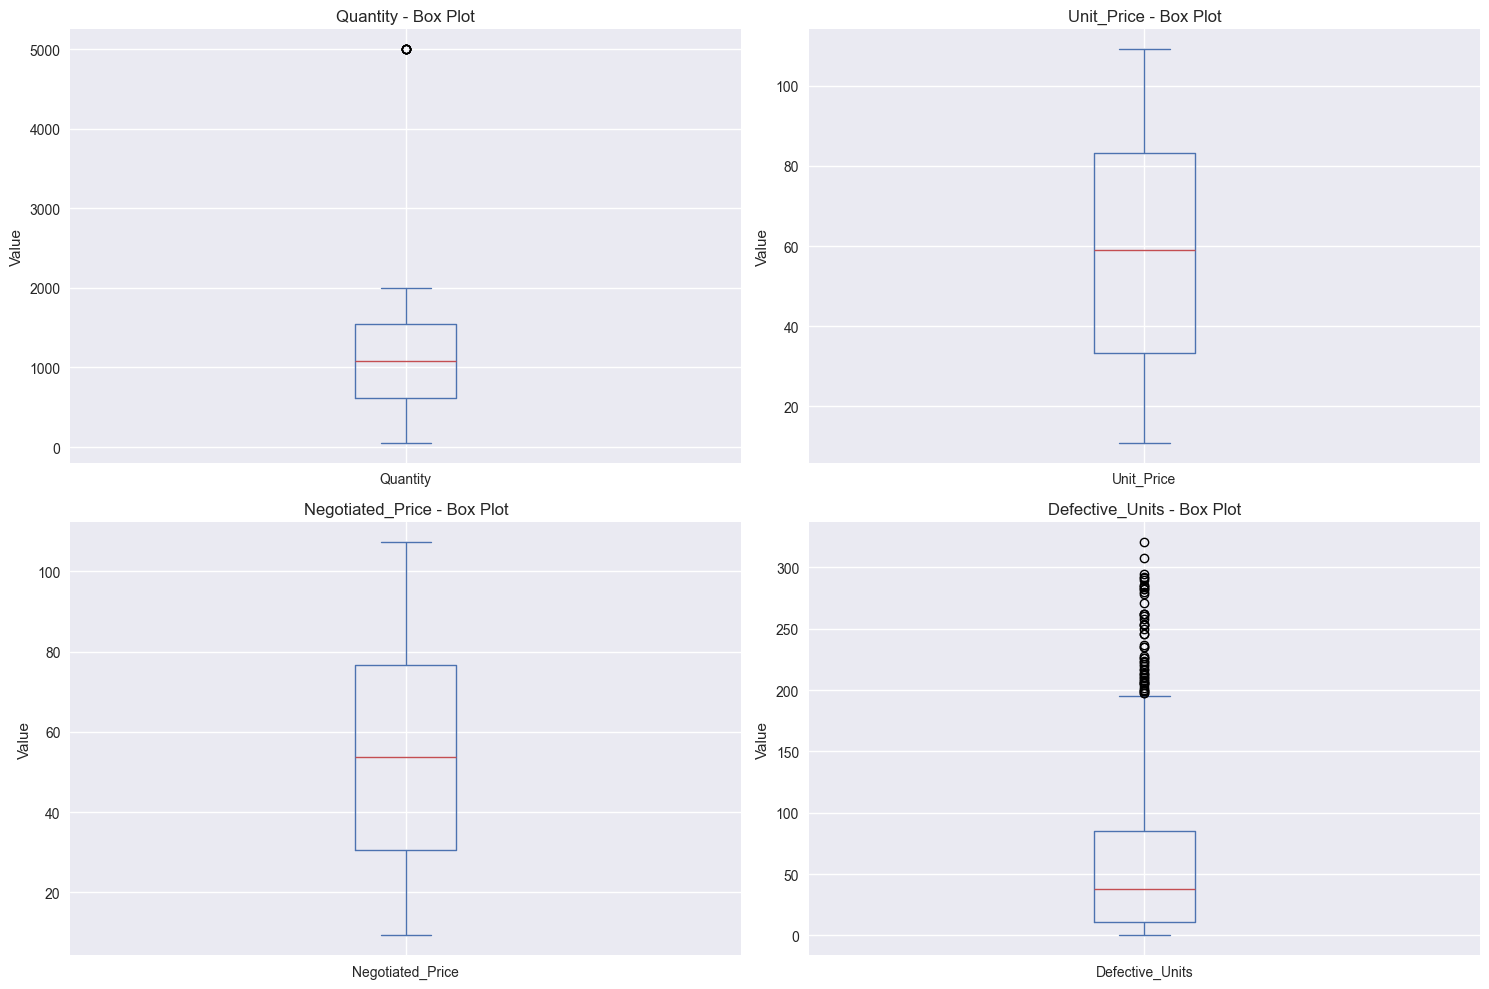


Outlier Summary:
Total outlier instances: 60
Percentage of dataset: 1.93%


In [12]:
# Visualize outliers
numerical_cols = ['Quantity', 'Unit_Price', 'Negotiated_Price', 'Defective_Units']
available_cols = [col for col in numerical_cols if col in df_validated.columns]

if available_cols:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, col in enumerate(available_cols[:4]):
        if i < len(axes):
            # Box plot
            df_validated[col].plot(kind='box', ax=axes[i])
            axes[i].set_title(f'{col} - Box Plot')
            axes[i].set_ylabel('Value')
    
    # Hide unused subplots
    for j in range(len(available_cols), len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Create outlier summary
total_outliers = sum(len(indices) for indices in outliers_detected.values())
print(f"\nOutlier Summary:")
print(f"Total outlier instances: {total_outliers}")
print(f"Percentage of dataset: {total_outliers/(len(df_validated)*len(available_cols))*100:.2f}%")

## 7. Create Clean Dataset

In [14]:
# Create final clean dataset
def create_clean_dataset(df: pd.DataFrame, handle_outliers: bool = False) -> pd.DataFrame:
    """
    Create final clean dataset with optional outlier handling.
    """
    df_final = df.copy()
    
    # Add data quality flags
    df_final['data_quality_score'] = 100  # Start with perfect score
    
    # Reduce score for various issues
    if 'excess_defects_flag' in df_final.columns:
        df_final.loc[df_final['excess_defects_flag'], 'data_quality_score'] -= 20
    
    # Add derived fields that might be useful
    if 'Order_Date' in df_final.columns and 'Delivery_Date' in df_final.columns:
        # Calculate lead time
        df_final['lead_time_days'] = (df_final['Delivery_Date'] - df_final['Order_Date']).dt.days
    
    if 'Unit_Price' in df_final.columns and 'Negotiated_Price' in df_final.columns and 'Quantity' in df_final.columns:
        # Calculate financial metrics
        df_final['total_original_value'] = df_final['Unit_Price'] * df_final['Quantity']
        df_final['total_negotiated_value'] = df_final['Negotiated_Price'] * df_final['Quantity']
        df_final['cost_savings'] = df_final['total_original_value'] - df_final['total_negotiated_value']
        df_final['savings_percentage'] = (df_final['cost_savings'] / df_final['total_original_value'] * 100).round(2)
    
    if 'Defective_Units' in df_final.columns and 'Quantity' in df_final.columns:
        # Calculate quality metrics
        df_final['defect_rate'] = (df_final['Defective_Units'] / df_final['Quantity'] * 100).round(2)
        df_final['quality_score'] = 100 - df_final['defect_rate']
    
    # Handle extreme outliers if requested
    if handle_outliers:
        # Cap extreme values rather than removing them
        numerical_cols = ['Quantity', 'Unit_Price', 'Negotiated_Price']
        for col in numerical_cols:
            if col in df_final.columns:
                # Cap at 99th percentile
                cap_value = df_final[col].quantile(0.99)
                outlier_count = (df_final[col] > cap_value).sum()
                if outlier_count > 0:
                    df_final[col] = df_final[col].clip(upper=cap_value)
                    print(f"Capped {outlier_count} extreme values in {col} at {cap_value:.2f}")
    
    return df_final

print("Creating Final Clean Dataset:")
print("=" * 50)

# Create clean dataset without outlier handling (preserve original data)
df_clean_final = create_clean_dataset(df_validated, handle_outliers=False)

print(f"Final dataset shape: {df_clean_final.shape}")
print(f"New columns added: {set(df_clean_final.columns) - set(df_raw.columns)}")

Creating Final Clean Dataset:
Final dataset shape: (777, 19)
New columns added: {'data_quality_score', 'lead_time_days', 'defect_rate', 'quality_score', 'total_original_value', 'total_negotiated_value', 'cost_savings', 'savings_percentage'}


In [15]:
# Final data quality summary
print("Final Data Quality Summary:")
print("=" * 50)

# Original vs cleaned comparison
print("Dataset Comparison:")
print(f"  Original records: {len(df_raw):,}")
print(f"  Final records: {len(df_clean_final):,}")
print(f"  Records retained: {len(df_clean_final)/len(df_raw)*100:.2f}%")

print(f"\n  Original columns: {len(df_raw.columns)}")
print(f"  Final columns: {len(df_clean_final.columns)}")
print(f"  New columns added: {len(df_clean_final.columns) - len(df_raw.columns)}")

# Missing values summary
original_missing = df_raw.isnull().sum().sum()
final_missing = df_clean_final.isnull().sum().sum()
print(f"\nMissing Values:")
print(f"  Original missing: {original_missing:,}")
print(f"  Final missing: {final_missing:,}")
print(f"  Missing values handled: {original_missing - final_missing:,}")

# Data quality score summary
if 'data_quality_score' in df_clean_final.columns:
    avg_quality_score = df_clean_final['data_quality_score'].mean()
    high_quality_records = (df_clean_final['data_quality_score'] >= 90).sum()
    print(f"\nData Quality Metrics:")
    print(f"  Average quality score: {avg_quality_score:.1f}/100")
    print(f"  High quality records (>=90): {high_quality_records:,} ({high_quality_records/len(df_clean_final)*100:.1f}%)")

Final Data Quality Summary:
Dataset Comparison:
  Original records: 777
  Final records: 777
  Records retained: 100.00%

  Original columns: 11
  Final columns: 19
  New columns added: 8

Missing Values:
  Original missing: 223
  Final missing: 174
  Missing values handled: 49

Data Quality Metrics:
  Average quality score: 100.0/100
  High quality records (>=90): 777 (100.0%)


## 8. Export Clean Data

In [16]:
# Export cleaned datasets
import os

# Ensure output directories exist
os.makedirs('../data/processed', exist_ok=True)
os.makedirs('../data/interim', exist_ok=True)

# Export main cleaned dataset
output_path = '../data/processed/procurement_data_clean.csv'
df_clean_final.to_csv(output_path, index=False)
print(f"Clean dataset exported to: {output_path}")

# Export data quality report
quality_report_path = '../data/processed/data_quality_report.csv'
final_quality_report = assess_data_quality(df_clean_final)
final_quality_report.to_csv(quality_report_path, index=False)
print(f"Quality report exported to: {quality_report_path}")

# Export cleaning summary
summary_path = '../data/processed/cleaning_summary.txt'
with open(summary_path, 'w') as f:
    f.write("PROCUREMENT DATA CLEANING SUMMARY\n")
    f.write("=" * 50 + "\n")
    f.write(f"Cleaning Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Original Dataset: {df_raw.shape[0]:,} rows x {df_raw.shape[1]} columns\n")
    f.write(f"Final Dataset: {df_clean_final.shape[0]:,} rows x {df_clean_final.shape[1]} columns\n")
    f.write(f"Records Retained: {len(df_clean_final)/len(df_raw)*100:.2f}%\n")
    f.write(f"Missing Values Handled: {original_missing - final_missing:,}\n")
    f.write(f"Business Rule Violations: {len(rule_violations)}\n")
    
    if rule_violations:
        f.write("\nRule Violations:\n")
        for violation in rule_violations:
            f.write(f"  - {violation}\n")
    
    f.write(f"\nNew Columns Added:\n")
    new_columns = set(df_clean_final.columns) - set(df_raw.columns)
    for col in sorted(new_columns):
        f.write(f"  - {col}\n")

print(f"Cleaning summary exported to: {summary_path}")

# Display final dataset sample
print(f"\nFinal Clean Dataset Sample:")
print("=" * 50)
display(df_clean_final.head())

print(f"\nData cleaning completed successfully!")
print(f"Files generated:")
print(f"  1. {output_path}")
print(f"  2. {quality_report_path}")
print(f"  3. {summary_path}")

Clean dataset exported to: ../data/processed/procurement_data_clean.csv
Quality report exported to: ../data/processed/data_quality_report.csv
Cleaning summary exported to: ../data/processed/cleaning_summary.txt

Final Clean Dataset Sample:


,PO_ID,Supplier,Order_Date,Delivery_Date,Item_Category,Order_Status,Quantity,Unit_Price,Negotiated_Price,Defective_Units,Compliance,data_quality_score,lead_time_days,total_original_value,total_negotiated_value,cost_savings,savings_percentage,defect_rate,quality_score
0,PO-00001,Alpha_Inc,2023-10-17,2023-10-25,Office Supplies,Cancelled,1176,20.13,17.81,0.00,Yes,100,8.00,23672.88,20944.56,2728.32,11.53,0.00,100.00
1,PO-00002,Delta_Logistics,2022-04-25,2022-05-05,Office Supplies,Delivered,1509,39.32,37.34,235.00,Yes,100,10.00,59333.88,56346.06,2987.82,5.04,15.57,84.43
2,PO-00003,Gamma_Co,2022-01-26,2022-02-15,MRO,Delivered,910,95.51,92.26,41.00,Yes,100,20.00,86914.10,83956.60,2957.50,3.40,4.51,95.49
3,PO-00004,Beta_Supplies,2022-10-09,2022-10-28,Packaging,Delivered,1344,99.85,95.52,112.00,Yes,100,19.00,134198.40,128378.88,5819.52,4.34,8.33,91.67
4,PO-00005,Delta_Logistics,2022-09-08,2022-09-20,Raw Materials,Delivered,1180,64.07,60.53,171.00,No,100,12.00,75602.60,71425.40,4177.20,5.53,14.49,85.51



Data cleaning completed successfully!
Files generated:
  1. ../data/processed/procurement_data_clean.csv
  2. ../data/processed/data_quality_report.csv
  3. ../data/processed/cleaning_summary.txt


---

## Data Cleaning Complete!

**Accomplishments:**
- Comprehensive data quality assessment
- Missing value handling with business logic
- Categorical data standardization
- Date format standardization
- Business rule validation
- Outlier detection and analysis
- Quality score assignment
- Derived field creation

**Key Outputs:**
- `../data/processed/procurement_data_clean.csv` - Main clean dataset
- `../data/processed/data_quality_report.csv` - Quality metrics
- `../data/processed/cleaning_summary.txt` - Detailed summary

**Next Steps:**
1. **Feature Engineering** (Notebook 03) - Create advanced analytical features
2. **KPI Analysis** (Notebook 04) - Calculate and analyze key performance indicators
3. **Supplier Performance** (Notebook 05) - Deep dive into supplier metrics

**Data Quality Notes:**
- Review any business rule violations flagged above
- Consider domain expert input for extreme outliers
- Validate derived calculations with business stakeholders

---